In [1]:
# Our stuff:
import casclik as cc
import casadi as cs
from urdf2casadi import converter, numpy_geom

# Plotting
from matplotlib import pyplot as plt
import common_plots
%matplotlib notebook

# UR5 Example - Simulated input at end-effector
Note: This example requires access to urdf2casadi, a python module for converting urdf files and kinematic chains to casadi functions describing their forward kinematics. This example is currently using the `sx_version` branch (1/10/2018).

First, let's define the basic symbols and limits:

In [2]:
t = cs.MX.sym("t")
q = cs.MX.sym("q",6) # six actuated joints
dq = cs.MX.sym("dq",6)
y = cs.MX.sym("y",3) # Three input channels 
max_speed = cs.np.pi/5 # rad/s
UR5_home = [0.0, -cs.np.pi/2, 0.0, -cs.np.pi/2, 0.0, 0.0]

## Get transformation matrix of forward kinematics
The converter creates a kinematic chain from a specific root link to an end link. Running `check_urdf` on the file, we find that the UR5 contains the links:
```
root Link: world has 1 child(ren)
    child(1):  base_link
        child(1):  base
        child(2):  shoulder_link
            child(1):  upper_arm_link
                child(1):  forearm_link
                    child(1):  wrist_1_link
                        child(1):  wrist_2_link
                            child(1):  wrist_3_link
                                child(1):  ee_link
                                child(2):  tool0
```

In [3]:
urdf_path = "./urdf/ur5.urdf"
links = ["world", 
         "base_link", 
         "base", 
         "shoulder_link", 
         "upper_arm_link", 
         "forearm_link", 
         "wrist_1_link", 
         "wrist_2_link", 
         "wrist_3_link", 
         "tool0"]
fk_dict = converter.from_file(root="base_link", tip="tool0", filename=urdf_path)

In [4]:
# Setup the function for the forward kinematics:
T_fk = fk_dict["T_fk"]
Q_fk = fk_dict["dual_quaternion_fk"]
# Test transformation matrix:
T0 = T_fk(UR5_home)
print("Distance to UR5Home pos: "+str(cs.norm_2(T0[:3,3])))

Distance to UR5Home pos: 1.0192


In [5]:
# Check the joint limits from the URDF:
q_max = cs.np.array(fk_dict["upper"])
q_min = cs.np.array(fk_dict["lower"])
print("q_min ",str(q_min))
print("q_max ",str(q_max))

q_min  [-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]
q_max  [6.28318531 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531]


In [6]:
# Define the basic system limits
# Uphold the joint constraints
joint_limits_cnstr = cc.SetConstraint(
    label="Joint_Limits",
    expression = q,
    set_min = q_min,
    set_max = q_max)

# Listify the joint limits constraints for pseudoinverse, starting with the lowest
joint_limits_cnstr_list = []
for i in range(q.size()[0]):
    joint_limits_cnstr_list.append(
    cc.SetConstraint(label="limit_q_"+str(i),
                     expression=q[i],
                     set_min = q_min[i],
                     set_max = q_max[i],
                    priority = i))

# Let's have some speed limit
joint_speed_limits_cnstr = cc.VelocitySetConstraint(
    label="Joint_speed_limits",
    expression = q,
    set_min = -cs.vertcat([max_speed]*q.size()[0]),
    set_max = cs.vertcat([max_speed]*q.size()[0]))

## Linear tracking skill (with simulated input)
In this example the robot wants to move to a specific frame, but if given linear input acting in x, y, or z, directions, it will comply. The simulated input is a small sinus signals in $x,y$ and $z$ that starts 10 seconds after the simulation starts.

From our previous example we know that the `transfmat_dist_id` approach did quite well as a constraint for matching a frame. So let's reuse that.

In [7]:
# Desired frame
roll = 0.0
pitch = 0.0
yaw = 0.0
des_position = [0.5, 0.5, 0.5]
T_des = cs.np.eye(4) 
T_des[:3,:3] = numpy_geom.rotation_rpy(roll, pitch, yaw)
T_des[:3,3] = [0.5,0.5,0.5] # Some desired position 
Q_des = numpy_geom.dual_quaternion_prismatic(des_position, [roll, pitch, yaw], [1,0,0],0)

In [8]:
# Disturbance function
omega = 0.1#cs.MX.sym("omega")
ampl = 0.1#cs.MX.sym("ampl")
fsine = cs.Function("fsine",[t],[ampl*cs.sin(omega*t)])
fcos = cs.Function("fcos", [t], [ampl*cs.cos(omega*t)])
dist_input = T_fk(q)[:3,3] - T_des[:3,3] + y

In [9]:
# Frame matching constraint
point_affected_cnstr = cc.EqualityConstraint(
    label="transfmat_dist_id",
    expression = T_fk(q)[:3,3] - T_des[:3,3] + y,
    constraint_type="soft",
    gain=1.0,
    priority=100)
point_affected_cnstr.eval = cs.Function("dist_input",[t,q,y],[cs.norm_2(dist_input)])

In [10]:
# Let's test all the relevant controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController
}
controllers = {"qp":{},"nlp":{}}#,"pinv":{}}

In [11]:
constraints = [point_affected_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
skill_spec = cc.SkillSpecification(
        label="linear_input_skill",
        time_var=t, robot_var=q, robot_vel_var=dq, input_var=y,
        constraints=constraints)
skill_spec.print_constraints()
print(skill_spec._has_input)

SkillSpecification: linear_input_skill
#0: Joint_Limits
#1: Joint_speed_limits
#2: transfmat_dist_id
Has virtual var: False
Has input var: True
N constraints: 3
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:1
True


In [12]:
# Setup all controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [point_affected_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [point_affected_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="linear_input_skill",
        time_var=t, robot_var=q, robot_vel_var=dq, input_var=y,
        constraints=constraints)
    controllers[key]["point_affected_cnstr"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["point_affected_cnstr"].setup_problem_functions()
    controllers[key]["point_affected_cnstr"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed nlp


In [13]:
dt = 0.01
timesteps = 4500
# Prepare input sequence
y_sim = cs.np.zeros((timesteps+1,y.shape[0]))
for i in range(timesteps):
    if dt*i > 10.0:
        y_sim[i,:] = [fcos(dt*i-10), fsine(dt*i-10+cs.np.pi/2),0]
# Run all the simulations:
for cntr_key in controllers.keys():
    print("Controller:"+cntr_key)
    print("\t\tSetting up initial value problem")
    controllers[cntr_key]["point_affected_cnstr"].setup_initial_problem_solver()
    slack_res = controllers[cntr_key]["point_affected_cnstr"].solve_initial_problem(time_var0=0,
                                                                                    robot_var0=UR5_home, 
                                                                                    input_var0=[0,0,0])[-1]
    print("\t\tSimulating:"+"point_affected_cnstr")
    # Simulate it!
    t_sim = cs.np.array([dt*i for i in range(timesteps+1)])
    # Robot
    q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
    q_sim[0,:] = UR5_home
    dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
    # Cartesian position
    p_sim = cs.np.zeros((len(t_sim), 3))
    p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
    # Rotation
    R_sim = cs.np.zeros((len(t_sim), 3, 3))
    R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
    # Error in constraint
    e_sim = cs.np.zeros(len(t_sim))
    e_sim[0] = point_affected_cnstr.eval(t_sim[0],q_sim[0,:], y_sim[0,:])
    # Loop
    #try:
    for i in range(len(t_sim) - 1):
        res = controllers[cntr_key]["point_affected_cnstr"].solve(t_sim[i],q_sim[i,:],input_var=y_sim[i,:],warmstart_slack_var=slack_res)
        dq_sim[i,:] = res[0].toarray()[:,0]
        if res[-1] is not None:
                slack_res = res[-1].toarray()[:,0]
        for idx, dqi in enumerate(dq_sim[i,:]):
            dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
        q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
        p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
        R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
        e_sim[i+1] = point_affected_cnstr.eval(t_sim[i],q_sim[i+1,:],y_sim[i+1,:])
    #except:
        #print("\tFAILED")
    controllers[cntr_key]["point_affected_cnstr_res"] = {
        "t_sim":t_sim,
        "dq_sim": dq_sim,
        "q_sim": q_sim,
        "p_sim": p_sim,
        "R_sim": R_sim,
        "e_sim": e_sim
    }

Controller:qp
		Setting up initial value problem
		Simulating:point_affected_cnstr
Controller:nlp
		Setting up initial value problem

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

		Simulating:point_affected_cnstr


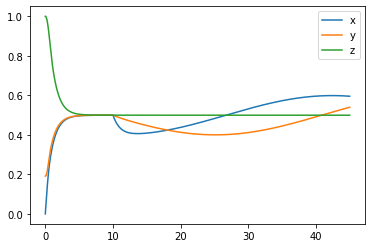

In [14]:
common_plots.pos_point(controllers["qp"]["point_affected_cnstr_res"])

<IPython.core.display.Javascript object>


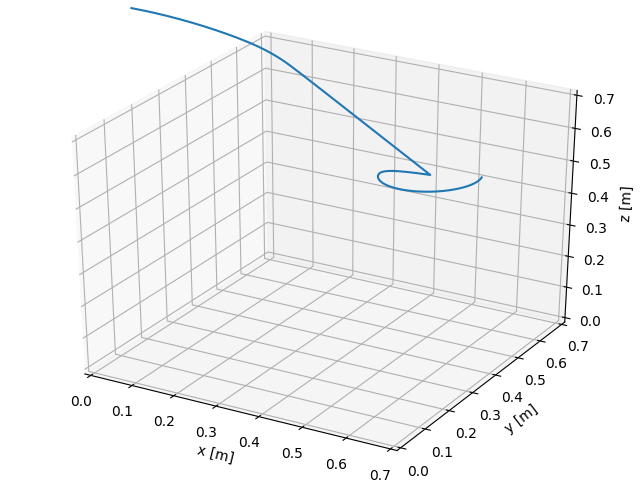

(0, 0.7)

In [15]:
%matplotlib notebook
ax = common_plots.pos_point_3d(controllers["nlp"]["point_affected_cnstr_res"])
ax.set_xlim([0, 0.7])
ax.set_ylim([0, 0.7])
ax.set_zlim([0, 0.7])

<IPython.core.display.Javascript object>


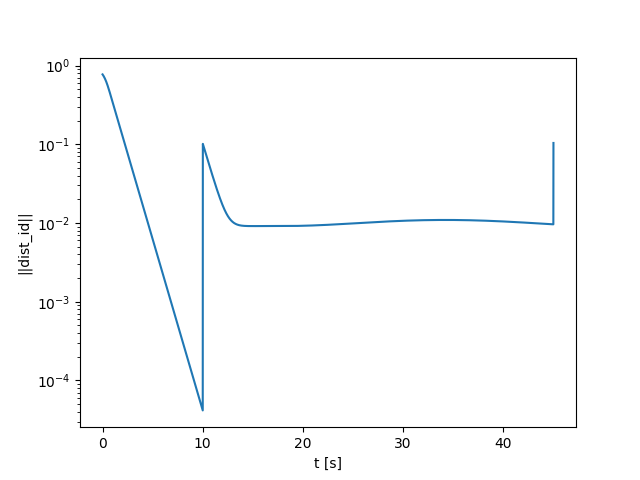

In [16]:
f,ax = plt.subplots()
ax.plot(controllers["nlp"]["point_affected_cnstr_res"]["t_sim"],
        controllers["nlp"]["point_affected_cnstr_res"]["e_sim"])
ax.set_xlabel("t [s]")
ax.set_ylabel("||dist_id||")
ax.set_yscale("log")

## Discussion
After 10 seconds, the input kicks in, and we start converging to the input signal instead. When we are tracking the input there is a significant tracking error. This can be reduced by increasing the gain, but is inherent to these constraint formulations as we do not have the derivative information. We can see that this error can be time varying, but does not drastically change.